In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import data
#path = r'C:\Users\Marcus\Downloads'
path = os.getcwd()
print("Current directory: ", path)
y = np.genfromtxt(path + '/seOMXlogreturns2012to2014.csv')

# Static parameters
phi = 0.98
sigma = 0.16
Beta = [0.5, 0.75, 1.0, 1.5, 2.0, 2.25] # Vary beta between 0 and 2

Current directory:  C:\Users\Marcus\workspace\smc_methods


## P1: Likelihood estimates for the stochastic volatility model

In [15]:
def bootstrap_particle_filter(y, n_particles, theta, resampling=True):
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.random.normal(0.0, sigma, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    X[0, :] = x
    W = np.zeros([T+1, n_particles])
    W[0, :] = w
    #W_tilde = np.zeros([T, n_particles])
    
    for t in range(T):
        
        if resampling:
            # Resample directly without saving ancestor indices
            x = np.random.choice(x, n_particles, p=w)
            
        x = np.random.normal(loc=phi*x, scale=sigma)
        log_w_tilde = norm.logpdf(y[t], loc=0.0, scale=beta * np.exp(x / 2) )
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde - max_w_tilde))) - np.log(n_particles)
        
        w = np.exp(log_w_tilde - max_w_tilde) / np.sum(np.exp(log_w_tilde - max_w_tilde))                          
        
        X[t+1, :] = x
        W[t+1, :] = w
        #W_tilde[t, :] = w_tilde
    return X, W, logl

beta:  0.5
beta:  0.75
beta:  1.0
beta:  1.5
beta:  2.0
beta:  2.25


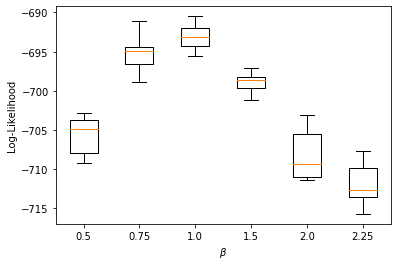

In [28]:
n_runs = 10
logl_list = []

N = 100

for i, beta in enumerate(Beta):
    #print("beta: ", beta)
    theta = [phi, sigma, beta]
    logl_beta = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, N, theta)
        #print("logl: ", logl)
        logl_beta.append(logl)
    logl_list.append(logl_beta)

# Plot boxplot
beta_list = [str(b) for b in Beta]
plt.boxplot(logl_list, showfliers=False, labels=beta_list)
plt.xlabel(r"$\beta$"); plt.ylabel("Log-Likelihood"); 
plt.show()

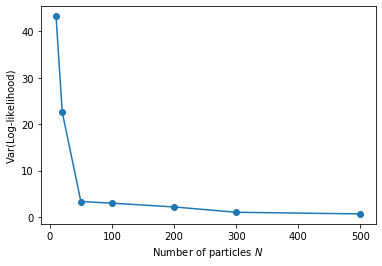

In [39]:
T = len(y)
n_runs = 10
logl_var = []
N = [10, 20, 50, 100, 200, 300, 500]
beta = 1.0
for i, n_particles in enumerate(N):
    theta = [phi, sigma, beta]
    logl_N = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, n_particles, theta)
        logl_N.append(logl)
    logl_var.append(np.var(logl_N))
# Plot variance of log-likelihood estimate over number of particles
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of particles $N$"); plt.ylabel("Var(Log-likelihood)")
plt.show()

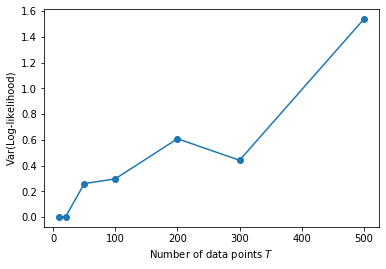

In [46]:
T = len(y)
n_runs = 10
logl_var = []
n_time_steps = [10, 20, 50, 100, 200, 300, 500]
n_particles = 200
beta = 1.0
for i, T in enumerate(n_time_steps):
    theta = [phi, sigma, beta]
    logl_T = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y[:T], n_particles, theta)
        logl_T.append(logl)
    logl_var.append(np.var(logl_T))
# Plot variance of log-likelihood estimate over number of data points (time steps)
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of data points $T$"); plt.ylabel("Var(Log-likelihood)")
plt.show()

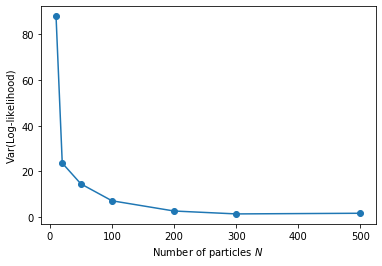

In [45]:
T = len(y)
n_runs = 10
logl_var = []
N = [10, 20, 50, 100, 200, 300, 500]
beta = 1.0
for i, n_particles in enumerate(N):
    theta = [phi, sigma, beta]
    logl_N = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, n_particles, theta, resampling=False)
        logl_N.append(logl)
    logl_var.append(np.var(logl_N))
# Plot variance of log-likelihood estimate over number of particles
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of particles $N$"); plt.ylabel("Var(Log-likelihood)")
plt.show()
# Variance of log-likelihood is bigger without resampling

## P2: Fully adapted particle filter

a) Full adaptation is possible whenever (x_t, y_t) are jointly Gaussian conditionally on x_{t-1}. This is the case when the transition density f(x_t | x_{t-1}) is Gaussian and the
measurement model g(y_t | x_t) is linear and Gaussian (page 83).

The SSMs (i) and (ii) have Gaussian noise in both transition density and measurement model. In SSM (iii), the measurement noise is modelled as a uniform distribution, which doesn't make 
the measurement model Gaussian.

In [6]:
import numpy as np
from scipy.stats import norm

def generate_data(n):
    y = np.zeros(n)
    x = np.random.normal(0, 1, size=1)
    for i in range(n):
        x = np.cos(x)**2 + np.random.normal(0, 1)
        y[i] = 2*x + np.random.normal(0, 0.01)
    return y

In [12]:
def fully_adapted_particle_filter(y, n_particles):
    
    T = len(y)
    
    # Initialization
    x = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    W = np.zeros([T+1, n_particles])
    X[0, :] = x
    W[0, :] = w
    
    for t in range(0, T):
        
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        v = norm.pdf(y[t], loc=2*x, scale=0.1)
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w * v) / np.sum(w*v)
        ancestors = np.random.choice(n_particles, n_particles, p=resampling_weights)
        x_resampled = x[ancestors]
        #x = np.random.normal(loc=cos(x[a])**2, scale=1.0)
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        
        
        
        print("v: ", v)
        print("w * v: ", p)
        print("normalizing weights: ", p / np.sum(p))
    

In [13]:
y = generate_data(3)
print("y: ", y)
fully_adapted_particle_filter(y, 3)

y:  [-1.45898514  1.29169284  3.56385074]
v:  [5.63516408e-218 1.03638188e-081 0.00000000e+000]
w * v:  [1.87838803e-218 3.45460628e-082 0.00000000e+000]
normalizing weights:  [5.43734328e-137 1.00000000e+000 0.00000000e+000]
v:  [6.76332849e-04 1.86797590e-14 1.65458884e-79]
w * v:  [2.25444283e-04 6.22658635e-15 5.51529614e-80]
normalizing weights:  [1.00000000e+00 2.76191805e-11 2.44641206e-76]
v:  [6.98437321e-075 1.00921254e-206 6.08102317e-003]
w * v:  [2.32812440e-075 3.36404181e-207 2.02700772e-003]
normalizing weights:  [1.14855231e-072 1.65960976e-204 1.00000000e+000]


In [ ]:
def bootstrap_particle_filter(y, n_particles, theta, resampling=True):
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.random.normal(0.0, sigma, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    X[0, :] = x
    W = np.zeros([T+1, n_particles])
    W[0, :] = w
    #W_tilde = np.zeros([T, n_particles])
    
    for t in range(T):
        
        if resampling:
            # Resample directly without saving ancestor indices
            x = np.random.choice(x, n_particles, p=w)
            
        x = np.random.normal(loc=phi*x, scale=sigma)
        log_w_tilde = norm.logpdf(y[t], loc=0.0, scale=beta * np.exp(x / 2) )
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde - max_w_tilde))) - np.log(n_particles)
        
        w = np.exp(log_w_tilde - max_w_tilde) / np.sum(np.exp(log_w_tilde - max_w_tilde))                          
        
        X[t+1, :] = x
        W[t+1, :] = w
        #W_tilde[t, :] = w_tilde
    return X, W, logl